# Calories Burned Exploration

**File:** Calories_Burned_Exploration.ipynb \
**Author:** Hunter Moricz \
**Last Modified:** May 23, 2025 \
**Data Source:** `calories.csv` - Licensed under CC0: Public Domain \
**Description:** This notebook explores the original, smaller dataset from which the synthetic competition data was generated. The purpose is to find key relationships and features in the original data to apply in our modelling of the competition data.

## Set Up

In [1]:
# Random Seed
seed = 3263463

#### Packages

In [ ]:
# Libraries
import time

# Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pipeline Functions
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Modelling Functions
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

#### Functions

In [3]:
# Root Mean Squared Logarithmic Error
def RMSLE(actual, prediction):
    """
    A function that takes two input arrays and returns the Root Mean Squared Logarithmic Error (RMSLE).
    
    Parameters
    ----------
    actual : array-like
        The true values.

    prediction : array-like
        The predictions.
    
    Returns
    -------
    float
        The RMSLE.
    """

    # Ensure inputs are numpy arrays
    try:
        actual = np.asarray(actual)
        prediction = np.asarray(prediction)
    except:
        raise TypeError('Could not convert the inputs to arrays.')

    # Check whether the arrays are of equal lengths
    if len(actual) != len(prediction):
        raise ValueError('The two input arrays must be of equal length.')
    
    # Ensure all the numbers in the arrays are non-negative
    if (actual<0).any() or (prediction<0).any():
        raise ValueError('The true values and predictions must both be non-negative.')

    # Return the RMSLE
    return float( np.sqrt( np.mean( (np.log(1+prediction) - np.log(1+actual)) ** 2 ) ) )


# Non-Negativity Criteria
def non_negative(array):
    """
    A function to ensure that all predictions are non-negative. 

    Parameters
    ----------
    array : array-like
        An array containing prediction values.
    
    Returns
    -------
    array-like
        An array containing non-negative predictions.
    """
    return np.clip(array, 0.0, None)

#### Reading

In [4]:
# Read in the data
data = pd.read_csv('Data/calories.csv', index_col='User_ID')
# Shape of the data
print(f'The dataset now has {data.shape[0]:,} rows and {data.shape[1]} columns. \nThere are a total of {data.isna().sum().sum()} missing values.')
# Check for missing values
data.isna().sum()

The dataset now has 15,000 rows and 8 columns. 
There are a total of 0 missing values.


Gender        0
Age           0
Height        0
Weight        0
Duration      0
Heart_Rate    0
Body_Temp     0
Calories      0
dtype: int64

## Feature Engineering
Due to my limited knowledge in the Exercise Physiology and Kinesiology, I utilized Google and AI sources for suggestions on features to engineer for predicting calorie burn. The main ones suggested were:
- BMI
- Senior
- Relative Intensity

Let's add these three features into the dataset.

In [5]:
# A numeric male indicator variable
data['Male'] = (data['Gender']=='male').astype(int)

# Senior indicator variable
data['Senior'] = (data['Age'] >= 60).astype(int)

# Body Mass Index (BMI)
data['BMI'] = data['Weight'] / (data['Height']/100)**2

# Maximum Heart Rate Estimation
data['max_HR'] = 208 - 0.7 * data['Age'] # Source: https://www.mayoclinic.org/healthy-lifestyle/fitness/in-depth/exercise-intensity/art-20046887

# Relative Intensity: Heart Rate / Estimated Maximum Heart Rate
data['Relative_Intensity'] = data['Heart_Rate'] / data['max_HR']

# Reorder the columns to have target on the end
data = data[['Gender', 'Male', 'Senior', 'Age', 'Weight', 'Height', 'BMI', 'max_HR', 'Heart_Rate', 'Relative_Intensity', 'Body_Temp', 'Duration', 'Calories']]
data.head()

Gender  Male  Senior  Age  Weight  Height        BMI  max_HR  \
User_ID                                                                  
14733363    male     1       1   68    94.0   190.0  26.038781   160.4   
14861698  female     0       0   20    60.0   166.0  21.773842   194.0   
11179863    male     1       1   69    79.0   179.0  24.655910   159.7   
16180408  female     0       0   34    71.0   179.0  22.159109   184.2   
17771927  female     0       0   27    58.0   154.0  24.456063   189.1   

          Heart_Rate  Relative_Intensity  Body_Temp  Duration  Calories  
User_ID                                                                  
14733363       105.0            0.654613       40.8      29.0     231.0  
14861698        94.0            0.484536       40.3      14.0      66.0  
11179863        88.0            0.551033       38.7       5.0      26.0  
16180408       100.0            0.542888       40.5      13.0      71.0  
17771927        81.0            0.428345       39.8      10.0      35.0

## Exploration

In [6]:
# Get a sense of the typcial values in the data
data_numeric = data.drop(columns=['Gender', 'Male', 'Senior'])
data_numeric.describe()

Age        Weight        Height           BMI        max_HR  \
count  15000.000000  15000.000000  15000.000000  15000.000000  15000.000000   
mean      42.789800     74.966867    174.465133     24.344900    178.047140   
std       16.980264     15.035657     14.258114      1.558784     11.886185   
min       20.000000     36.000000    123.000000     19.227688    152.700000   
25%       28.000000     63.000000    164.000000     23.243408    168.800000   
50%       39.000000     74.000000    175.000000     24.376731    180.700000   
75%       56.000000     87.000000    185.000000     25.492722    188.400000   
max       79.000000    132.000000    222.000000     29.069767    194.000000   

         Heart_Rate  Relative_Intensity     Body_Temp      Duration  \
count  15000.000000        15000.000000  15000.000000  15000.000000   
mean      95.518533            0.539008     40.025453     15.530600   
std        9.583328            0.066168      0.779230      8.319203   
min       67.000000            0.356958     37.100000      1.000000   
25%       88.000000            0.490144     39.600000      8.000000   
50%       96.000000            0.536111     40.200000     16.000000   
75%      103.000000            0.582696     40.600000     23.000000   
max      128.000000            0.790997     41.500000     30.000000   

           Calories  
count  15000.000000  
mean      89.539533  
std       62.456978  
min        1.000000  
25%       35.000000  
50%       79.000000  
75%      138.000000  
max      314.000000

#### Plots

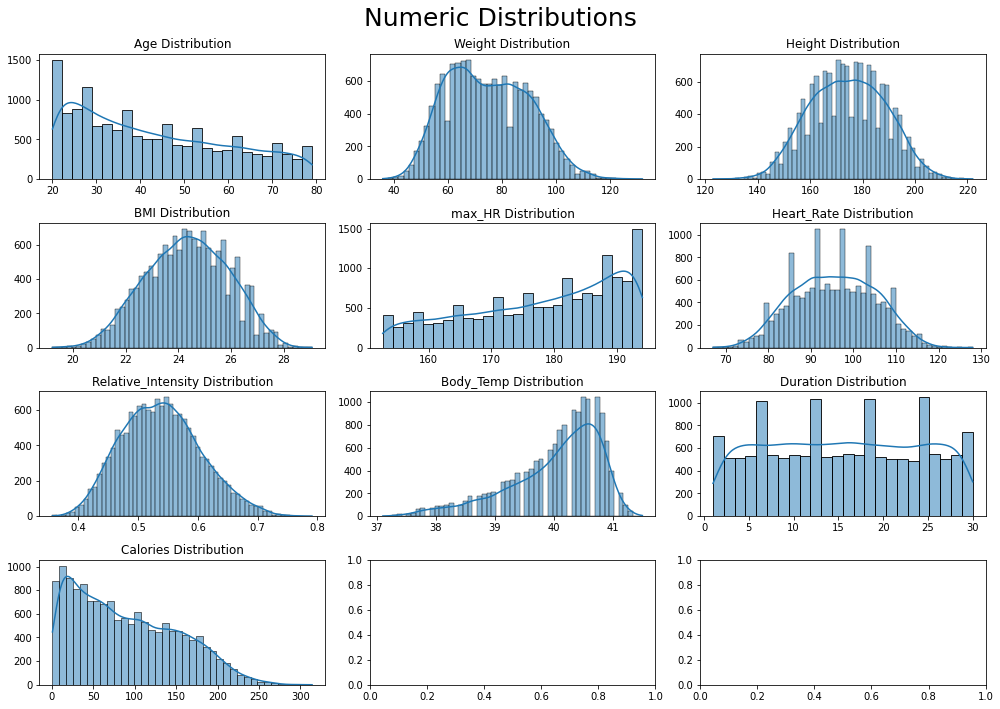

In [7]:
# Plot the distributions of the numeric features with Histograms
fig, ax = plt.subplots(4, 3, figsize=(14, 10))
i = 0
j = 0
for col in data_numeric.columns:
    sns.histplot(data[col], ax=ax[i][j], kde=True)
    ax[i][j].set_title(f'{col} Distribution')
    ax[i][j].set_xlabel('')
    ax[i][j].set_ylabel('')
    # Increment i and j
    j += 1
    if (j % 3 == 0) and (j != 0):
        i += 1
        j = 0
fig.suptitle('Numeric Distributions', fontsize=25)
plt.tight_layout()
plt.show()

**Notes**
- Height, Weight, Heart Rate, and Relative Intensity have relatively normal distributions.
- Body Temperature's distribution is left-skewed.
- The distribution of Calories and Age are heavily right-skewed.
- Duration has a relatively flat distribution with some spikes in the counts.
- Max Heart Rate has a mirrored distribution relative to the distribution of the Age variable, with a heavy left-skew.

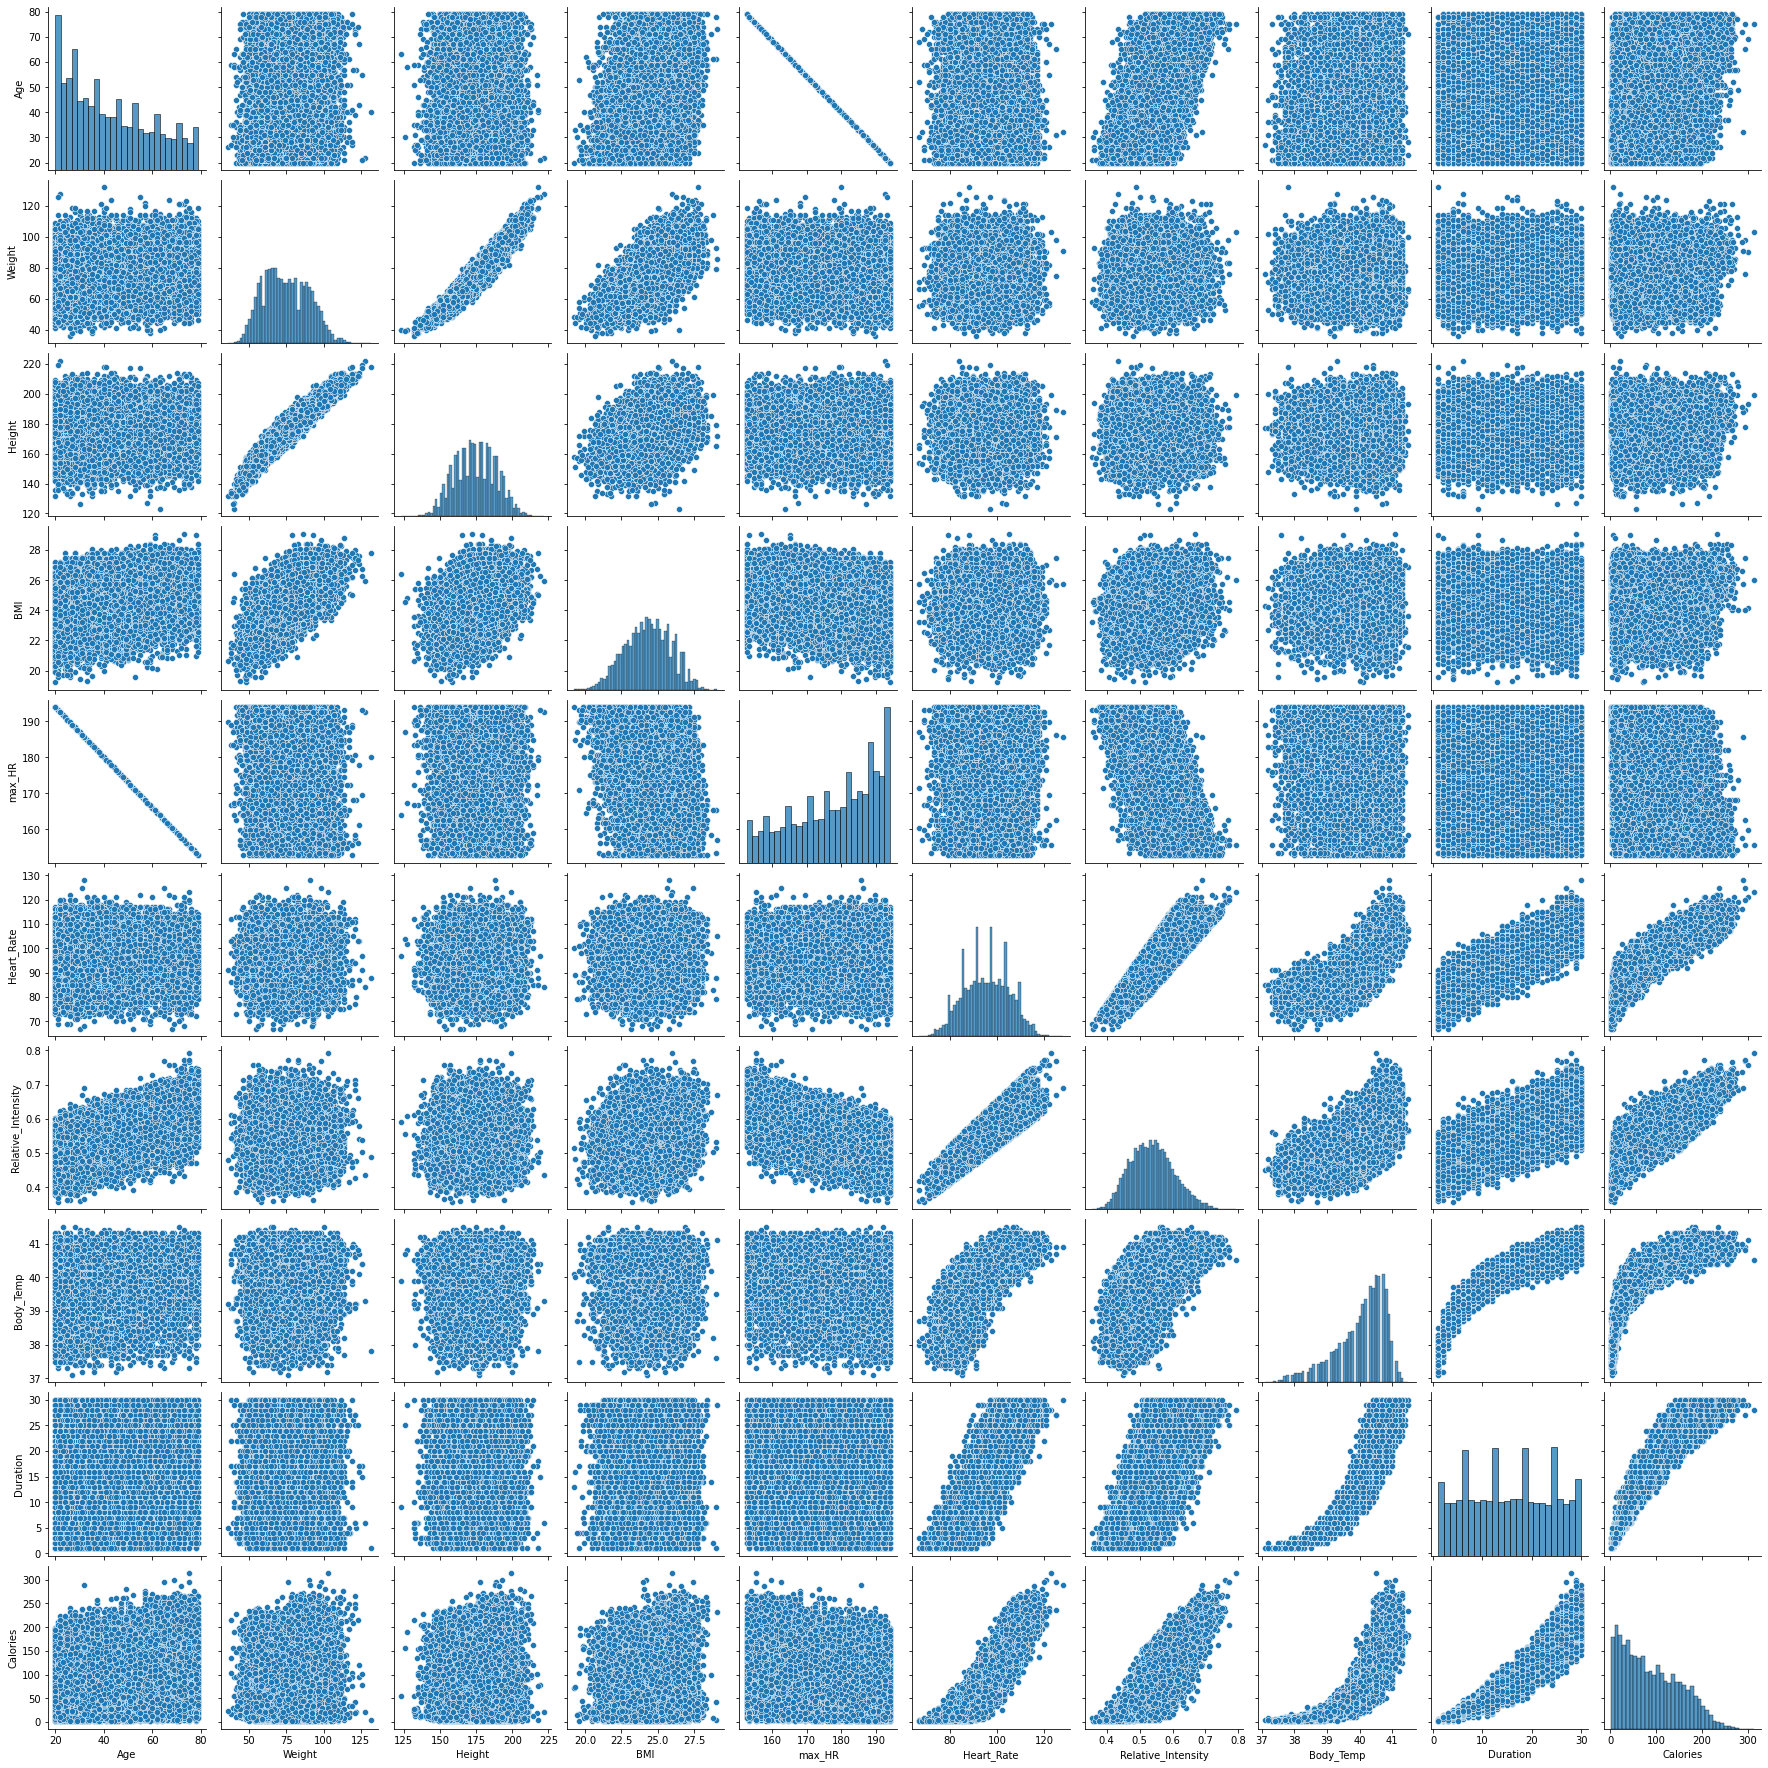

In [8]:
# Visualize all distributions in the data with a pairplot to detect the relationships with the target and any potential multicollinearity.
sns.pairplot(data_numeric)
plt.show()

We see some multicollinearity between age and weight, and as well as between duration, heart rate, and body temperature. Most of the relationships with the target appear to be non-linear.

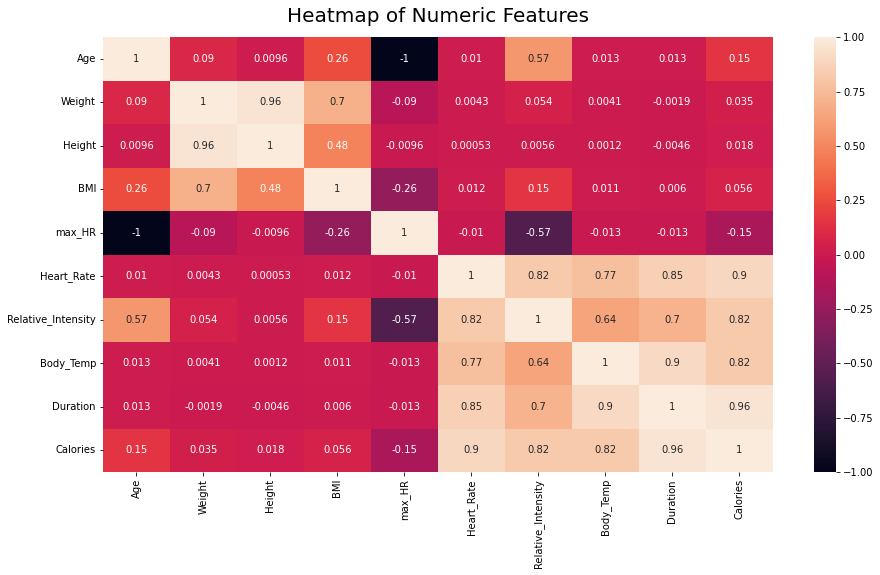

In [9]:
# Correlation Heatmap - look at the linear correlations with the target
plt.figure(figsize=(15,8))
sns.heatmap(data_numeric.corr(), annot=True)
plt.title('Heatmap of Numeric Features', fontsize='20', pad=15)
plt.show()

Calorie burn appears to have the strongest linear correlation with duration and heart rate, as well as body temperature. Age seems to only have a very mild correlation.

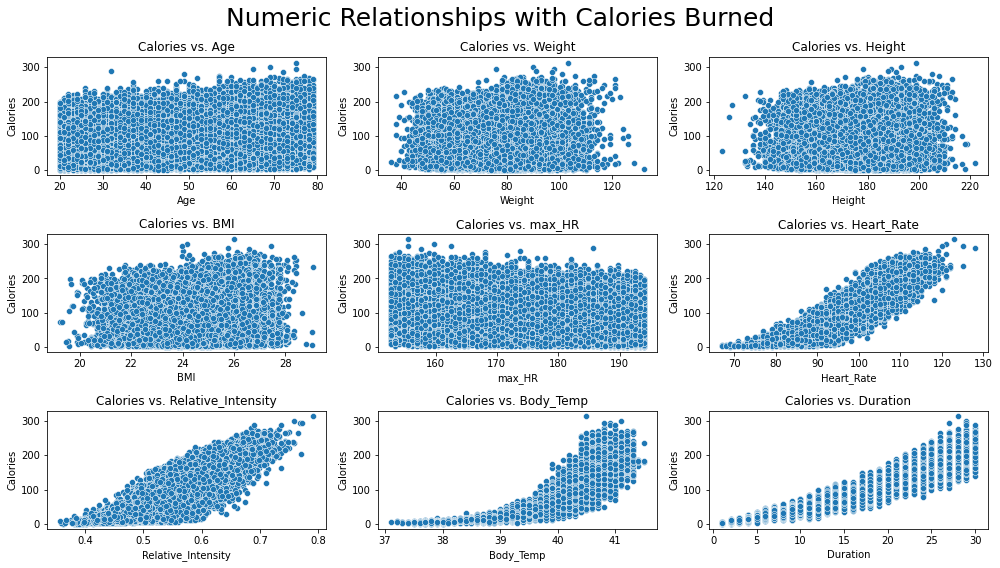

In [10]:
# Plot numeric relationships with the target variable `Calories`` in scatterplots
fig, ax = plt.subplots(3, 3, figsize=(14, 8))
i = 0
j = 0
for col in data_numeric.columns[:-1]:
    sns.scatterplot(data_numeric, x=col, y='Calories', ax=ax[i,j])
    ax[i][j].set_title(f'Calories vs. {col}')
    # Increment j
    j += 1
    # Check if I needs to be incremented and j needs to be reset
    if (j % 3 == 0) and (j != 0):
        i += 1
        j = 0
fig.suptitle('Numeric Relationships with Calories Burned', fontsize=25)
plt.tight_layout()
plt.show()

We don't see too many linear relationships in the data. Duration has a slight upward curve, and heart rate and body temperature have a polynomial or exponential relationship.

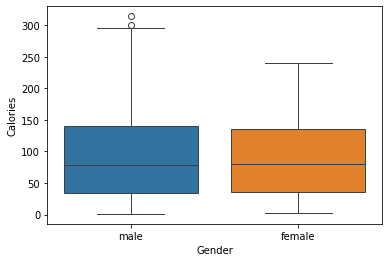

Proportion Male: 49.65%
Proportion Female: 50.35%


In [11]:
# Investigate our the effect of our single categorical variable, `Gender`, on the target.
sns.boxplot(data, x='Gender', y='Calories', hue='Gender')
plt.show()

print(f"Proportion Male: {round((data['Gender']=='male').sum() / len(data)*100, 2)}%")
print(f"Proportion Female: {round((data['Gender']=='female').sum() / len(data)*100, 2)}%")

The effect appears to be quite similar, with the median and the spread being fairly comparable. There are a couple potential male outliers or extreme values. It is worth noting that male and female results should be compared by fixing other variables such as exercise duration and intensity.

## Wrangling

I am going to apply transformations to make Calories and Body Temperature more normally distributed.

In [12]:
# Apply a sqrt-transformation on the target
data['sqrt(Calories)'] = np.sqrt(data['Calories'])
# Apply a exponential-transformation to the feature `Body_Temp`
data['1.75^Body_Temp'] = np.power(1.75, data['Body_Temp'])
# Show the data
data.head()

Gender  Male  Senior  Age  Weight  Height        BMI  max_HR  \
User_ID                                                                  
14733363    male     1       1   68    94.0   190.0  26.038781   160.4   
14861698  female     0       0   20    60.0   166.0  21.773842   194.0   
11179863    male     1       1   69    79.0   179.0  24.655910   159.7   
16180408  female     0       0   34    71.0   179.0  22.159109   184.2   
17771927  female     0       0   27    58.0   154.0  24.456063   189.1   

          Heart_Rate  Relative_Intensity  Body_Temp  Duration  Calories  \
User_ID                                                                   
14733363       105.0            0.654613       40.8      29.0     231.0   
14861698        94.0            0.484536       40.3      14.0      66.0   
11179863        88.0            0.551033       38.7       5.0      26.0   
16180408       100.0            0.542888       40.5      13.0      71.0   
17771927        81.0            0.428345       39.8      10.0      35.0   

          sqrt(Calories)  1.75^Body_Temp  
User_ID                                   
14733363       15.198684    8.240478e+09  
14861698        8.124038    6.229216e+09  
11179863        5.099020    2.544324e+09  
16180408        8.426150    6.966922e+09  
17771927        5.916080    4.708844e+09

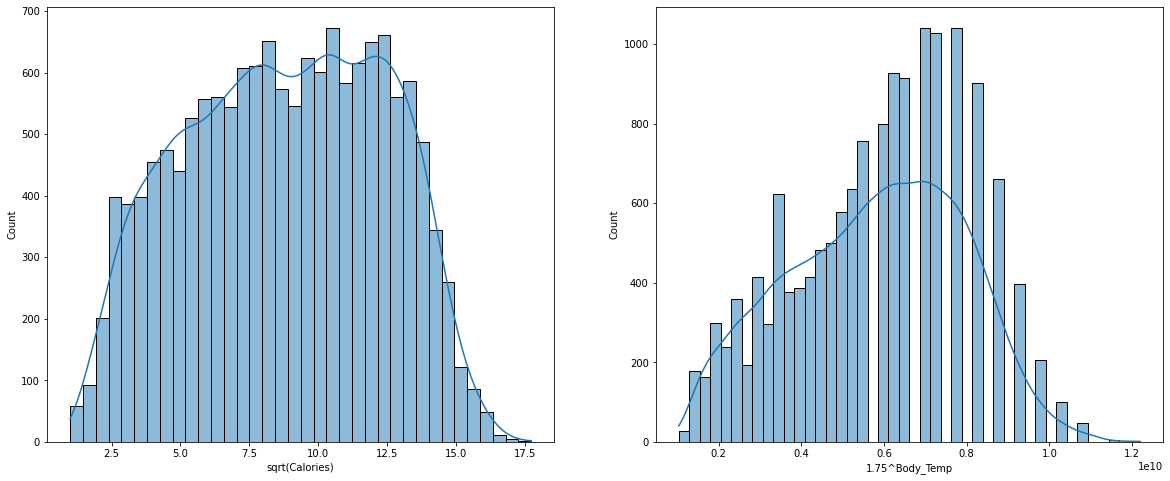

In [13]:
# Check the new distributions
fig, axes = plt.subplots(1,2, figsize=(20,8))
sns.histplot(data=data, x='sqrt(Calories)', kde=True, ax=axes[0])
sns.histplot(data=data, x='1.75^Body_Temp', kde=True, ax=axes[1])
plt.show()

After playing around with some transformations, I found that the best transformation for calories seems to be a square-root transformation, as a logarithmic transformation is too extreme and causes calories to go from a right-skew to a left-skew, whereas a square-root transformation causes the data to be more normal and identical.

Age does not have a good transformation, most of ages transformations lead to a uniform distribution.

Body Temperature requires an exponential transformation to make it approach a normal distribution. This may be extreme and I am apprehensive about using this transformation in the modelling.

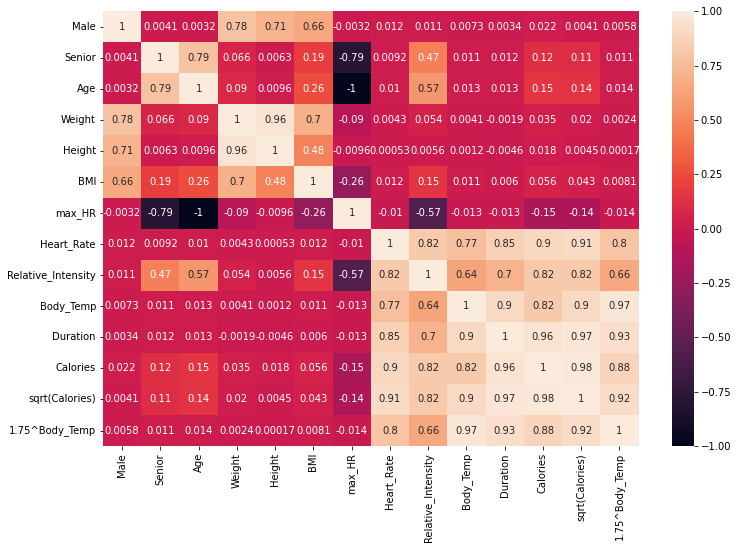

In [14]:
# New correlation heatmap with the transformed values
plt.figure(figsize=(12,8))
sns.heatmap(data.drop(columns=['Gender']).corr(), annot=True)
plt.show()

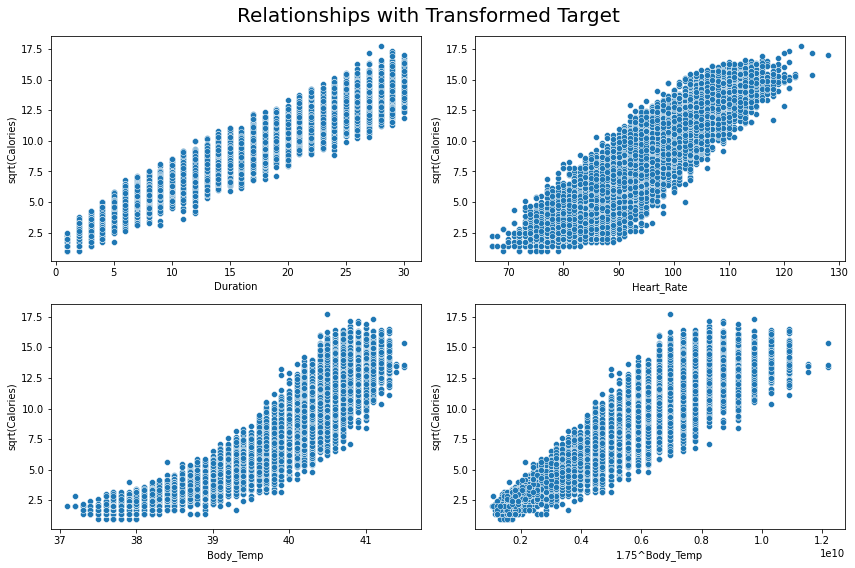

In [15]:
# Examine how the current promising features correlate with the transformed target.
fig, axes = plt.subplots(2,2, figsize=(12,8))
i=0
j=0
for col in ['Duration', 'Heart_Rate', 'Body_Temp', '1.75^Body_Temp']:
    sns.scatterplot(data, x=col, y='sqrt(Calories)', ax=axes[i][j])
    j+=1
    if j%2==0 and j!=0:
        j=0
        i+=1
fig.suptitle('Relationships with Transformed Target', fontsize=20)
plt.tight_layout()
plt.show()

These relationships are now far more linear; although, the original body temperature still has a non-linear relationship, and using the transformed body temperature leads to heteroskedasticity.

## Investigating Interactions
Since duration and heart rate seem to be the best predictors (intensity over time), I am curious how gender, age, and weight, and height affect the number of calories burned when duration and heart rate are fixed.

In [16]:
# Create categorical variables out of duration and intensity using binning
data['Duration_Zone'] = pd.cut(data['Duration'], bins=5, labels=['minimal', 'short', 'medium', 'long', 'very long'])
data['Intensity_Zone'] = pd.cut(data['Relative_Intensity'], bins=3, labels=['light', 'moderate', 'intense'])
data.head()

Gender  Male  Senior  Age  Weight  Height        BMI  max_HR  \
User_ID                                                                  
14733363    male     1       1   68    94.0   190.0  26.038781   160.4   
14861698  female     0       0   20    60.0   166.0  21.773842   194.0   
11179863    male     1       1   69    79.0   179.0  24.655910   159.7   
16180408  female     0       0   34    71.0   179.0  22.159109   184.2   
17771927  female     0       0   27    58.0   154.0  24.456063   189.1   

          Heart_Rate  Relative_Intensity  Body_Temp  Duration  Calories  \
User_ID                                                                   
14733363       105.0            0.654613       40.8      29.0     231.0   
14861698        94.0            0.484536       40.3      14.0      66.0   
11179863        88.0            0.551033       38.7       5.0      26.0   
16180408       100.0            0.542888       40.5      13.0      71.0   
17771927        81.0            0.428345       39.8      10.0      35.0   

          sqrt(Calories)  1.75^Body_Temp Duration_Zone Intensity_Zone  
User_ID                                                                
14733363       15.198684    8.240478e+09     very long        intense  
14861698        8.124038    6.229216e+09        medium          light  
11179863        5.099020    2.544324e+09       minimal       moderate  
16180408        8.426150    6.966922e+09        medium       moderate  
17771927        5.916080    4.708844e+09         short          light

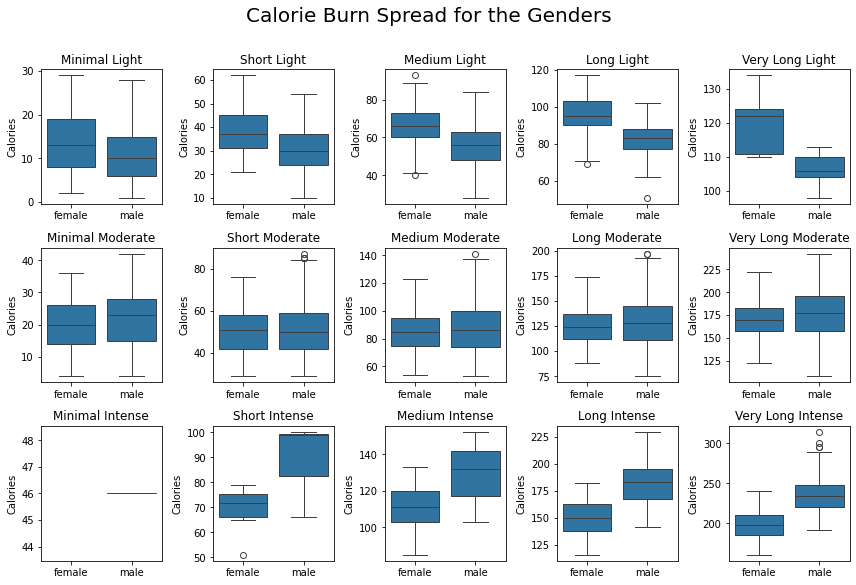

In [ ]:
# Examine the effect of gender when fixing duration and heart rate
fig, axes = plt.subplots(3, 5, figsize=(12,8))
i = 0
j = 0
for length in ['minimal', 'short', 'medium', 'long', 'very long']:
    for intensity in ['light', 'moderate', 'intense']:
        filtered_data = data[(data['Duration_Zone']==length) & (data['Intensity_Zone']==intensity)]
        if len(filtered_data) == 0:
            # Go to the next axes
            i+=1
            if i % 3 == 0:
                i=0
                j+=1
            continue
        sns.boxplot(filtered_data, x='Gender', y='Calories', order=['female', 'male'], ax=axes[i][j])
        axes[i][j].set_title(length.title() + ' ' + intensity.title())
        axes[i][j].set_xlabel('')

        # Go to the next axes
        i+=1
        if i % 3 == 0:
            i=0
            j+=1

fig.suptitle('Calorie Burn Spread for the Genders', fontsize=20, y=1.01)
plt.tight_layout()
plt.show()

Based on a preliminary examination of these boxplots, gender may have an interaction effect with the fixed variables (duration and/or intensity). For example, females seem to burn many more calories from long, light exercises, whereas males seem to burn more calories at the higher intensities. It is worth noting that weight may be an additional confounding variable at play here.

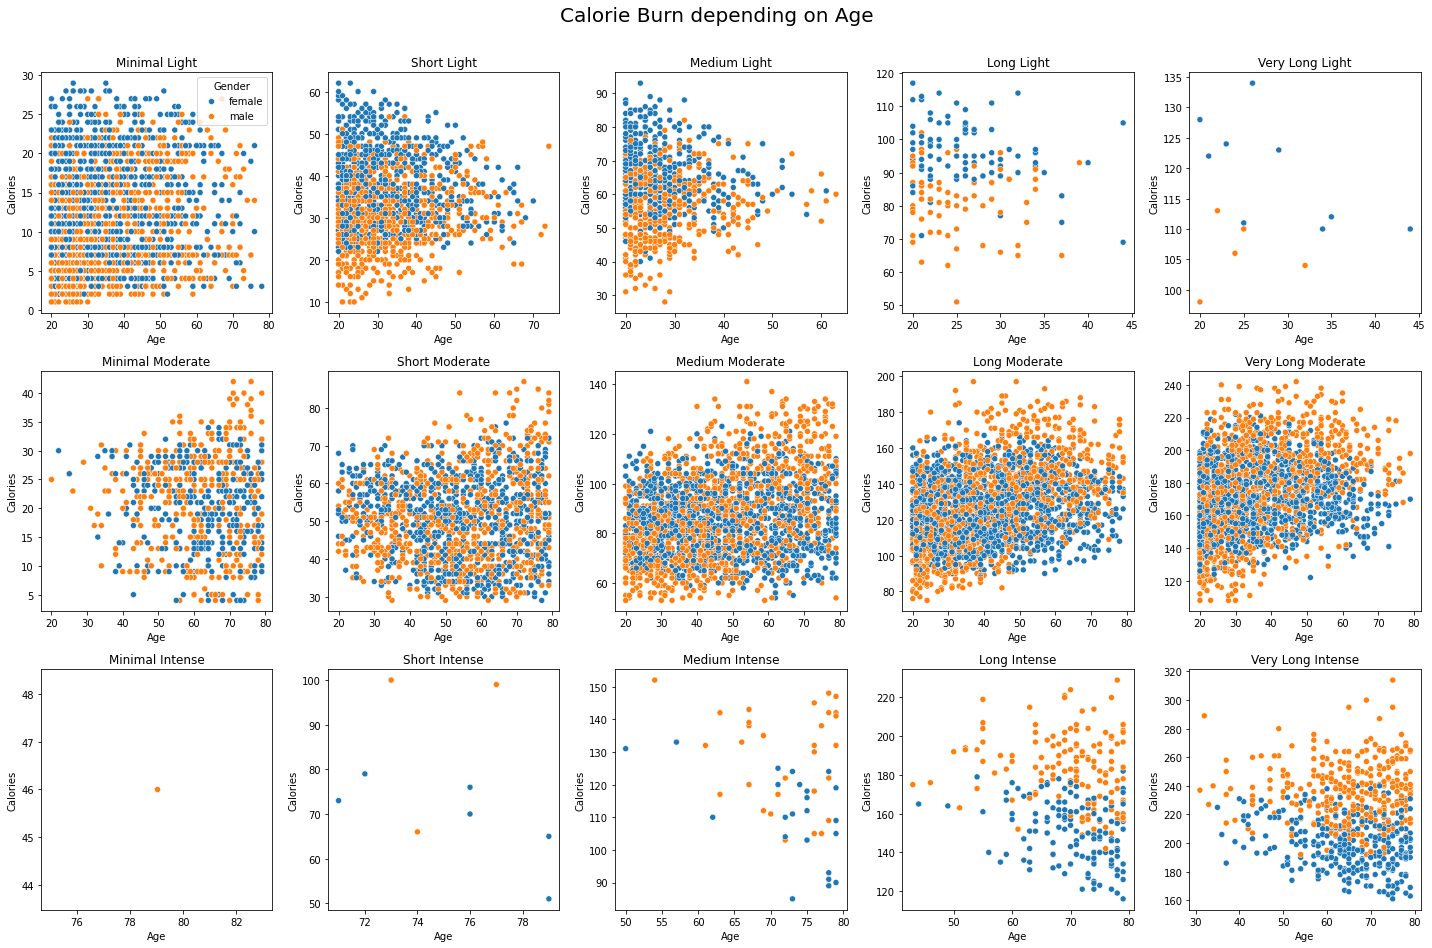

In [ ]:
# Examine the effect of age when fixing duration and heart rate
fig, axes = plt.subplots(3, 5, figsize=(20,13))
i = 0
j = 0
for length in ['minimal', 'short', 'medium', 'long', 'very long']:
    for intensity in ['light', 'moderate', 'intense']:
        filtered_data = data[(data['Duration_Zone']==length) & (data['Intensity_Zone']==intensity)]
        if len(filtered_data) == 0:
            # Go to the next axes
            i+=1
            if i % 3 == 0:
                i=0
                j+=1
            continue
        sns.scatterplot(filtered_data, x='Age', y='Calories', hue='Gender', hue_order=['female', 'male'], ax=axes[i][j])
        axes[i][j].set_title(length.title() + ' ' + intensity.title())
        if i!=0 or j!=0:
            axes[i][j].legend_.remove()

        # Go to the next axes
        i+=1
        if i % 3 == 0:
            i=0
            j+=1
        
fig.suptitle('Calorie Burn depending on Age', fontsize=20, y=1.01)
plt.tight_layout()
plt.show()

Depending on the bin for duration and intensity, age may either have no relationship or a slight positive relationship.

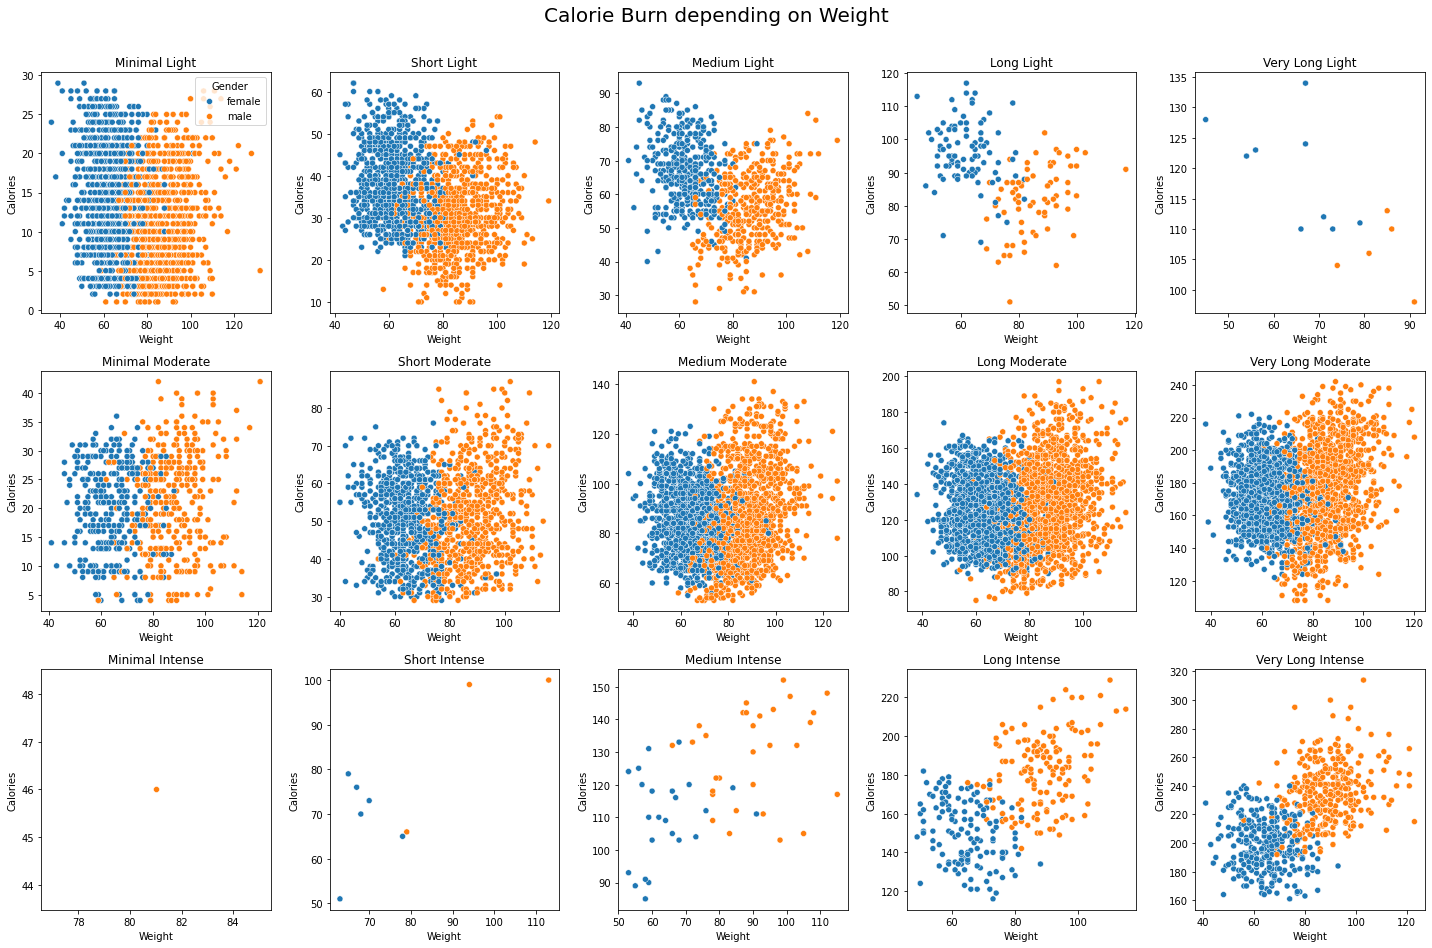

In [ ]:
# Examine the effect of weight when fixing duration and heart rate
fig, axes = plt.subplots(3, 5, figsize=(20,13))
i = 0
j = 0
for length in ['minimal', 'short', 'medium', 'long', 'very long']:
    for intensity in ['light', 'moderate', 'intense']:
        filtered_data = data[(data['Duration_Zone']==length) & (data['Intensity_Zone']==intensity)]
        if len(filtered_data) == 0:
            # Go to the next axes
            i+=1
            if i % 3 == 0:
                i=0
                j+=1
            continue
        sns.scatterplot(filtered_data, x='Weight', y='Calories', hue='Gender', hue_order=['female', 'male'], ax=axes[i][j])
        axes[i][j].set_title(length.title() + ' ' + intensity.title())
        if i!=0 or j!=0:
            axes[i][j].legend_.remove()

        # Go to the next axes
        i+=1
        if i % 3 == 0:
            i=0
            j+=1
        
fig.suptitle('Calorie Burn depending on Weight', fontsize=20, y=1.01)
plt.tight_layout()
plt.show()

Weight may have some effect on calorie burn; it may have an interaction effect involving gender and the duration-intensity combination.

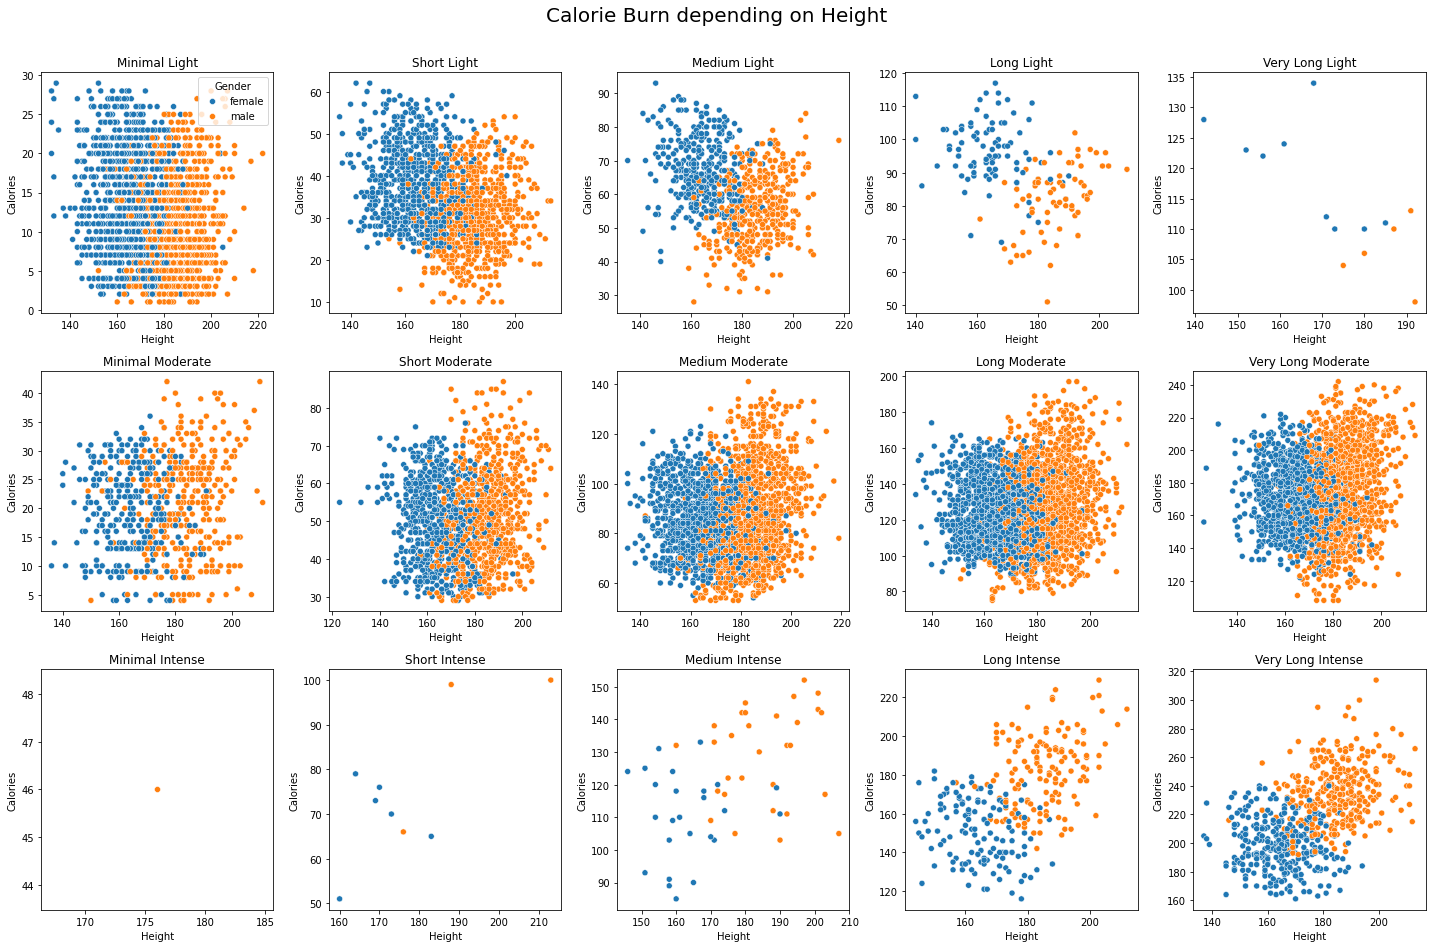

In [ ]:
# Examine the effect of height when fixing duration and heart rate
fig, axes = plt.subplots(3, 5, figsize=(20,13))
i = 0
j = 0
for length in ['minimal', 'short', 'medium', 'long', 'very long']:
    for intensity in ['light', 'moderate', 'intense']:
        filtered_data = data[(data['Duration_Zone']==length) & (data['Intensity_Zone']==intensity)]
        if len(filtered_data) == 0:
            # Go to the next axes
            i+=1
            if i % 3 == 0:
                i=0
                j+=1
            continue
        sns.scatterplot(filtered_data, x='Height', y='Calories', hue='Gender', hue_order=['female', 'male'], ax=axes[i][j])
        axes[i][j].set_title(length.title() + ' ' + intensity.title())
        if i!=0 or j!=0:
            axes[i][j].legend_.remove()

        # Go to the next axes
        i+=1
        if i % 3 == 0:
            i=0
            j+=1
        
fig.suptitle('Calorie Burn depending on Height', fontsize=20, y=1.01)
plt.tight_layout()
plt.show()

Height appears to have similar results to weight.

## Interactions
I am now going to explore potential interaction terms that may help improve the model. It is worth noting, however, that these are not features derived from domain knowledge in Physiology or Exercise Science, but rather experimenting in ML performance. While having this many interactions may seem excessive, they help the performance of the MLP models - note that they don't really help the tree-based models.

In [21]:
## Two-Way Interactions
# Time Interactions
data['Duration*Age'] = data['Duration']*data['Age']
data['Duration*Weight'] = data['Duration']*data['Weight']
data['Duration*Relative_Intensity'] = data['Duration']*data['Relative_Intensity']
data['Duration*Heart_Rate'] = data['Duration']*data['Heart_Rate']
data['Duration*Body_Temp'] = data['Duration']*data['Body_Temp']

# Intensity Interactions
data['Relative_Intensity*Age'] = data['Relative_Intensity']*data['Age']
data['Relative_Intensity*Weight'] = data['Relative_Intensity']*data['Weight']
data['Relative_Intensity*Body_Temp'] = data['Relative_Intensity']*data['Body_Temp']

# Age Interactions
data['Age*Heart_Rate'] = data['Age']*data['Heart_Rate']
data['Senior*Male'] = data['Senior']*data['Male']
data['Age*Body_Temp'] = data['Age']*data['Body_Temp']

# Weight Interaction
data['Weight*Heart_Rate'] = data['Weight']*data['Heart_Rate']
data['Weight*Body_Temp'] = data['Weight']*data['Body_Temp']

## Three-Way Interactions
data['Age*Weight*Duration'] = data['Age']*data['Weight']*data['Duration']
data['Weight*Duration*Relative_Intensity'] = data['Weight']*data['Duration']*data['Relative_Intensity']

## Four-Way Interactions
data['Age*Weight*Duration*Relative_Intensity'] = data['Age']*data['Weight']*data['Duration']*data['Relative_Intensity']

data.head()

Gender  Male  Senior  Age  Weight  Height        BMI  max_HR  \
User_ID                                                                  
14733363    male     1       1   68    94.0   190.0  26.038781   160.4   
14861698  female     0       0   20    60.0   166.0  21.773842   194.0   
11179863    male     1       1   69    79.0   179.0  24.655910   159.7   
16180408  female     0       0   34    71.0   179.0  22.159109   184.2   
17771927  female     0       0   27    58.0   154.0  24.456063   189.1   

          Heart_Rate  Relative_Intensity  ...  Relative_Intensity*Weight  \
User_ID                                   ...                              
14733363       105.0            0.654613  ...                  61.533666   
14861698        94.0            0.484536  ...                  29.072165   
11179863        88.0            0.551033  ...                  43.531622   
16180408       100.0            0.542888  ...                  38.545060   
17771927        81.0            0.428345  ...                  24.843998   

          Relative_Intensity*Body_Temp  Age*Heart_Rate  Senior*Male  \
User_ID                                                               
14733363                     26.708229          7140.0            1   
14861698                     19.526804          1880.0            0   
11179863                     21.324984          6072.0            1   
16180408                     21.986971          3400.0            0   
17771927                     17.048123          2187.0            0   

          Age*Body_Temp Weight*Heart_Rate Weight*Body_Temp  \
User_ID                                                      
14733363         2774.4            9870.0           3835.2   
14861698          806.0            5640.0           2418.0   
11179863         2670.3            6952.0           3057.3   
16180408         1377.0            7100.0           2875.5   
17771927         1074.6            4698.0           2308.4   

          Age*Weight*Duration  Weight*Duration*Relative_Intensity  \
User_ID                                                             
14733363             185368.0                         1784.476309   
14861698              16800.0                          407.010309   
11179863              27255.0                          217.658109   
16180408              31382.0                          501.085776   
17771927              15660.0                          248.439979   

          Age*Weight*Duration*Relative_Intensity  
User_ID                                           
14733363                           121344.389027  
14861698                             8140.206186  
11179863                            15018.409518  
16180408                            17036.916395  
17771927                             6707.879429  

[5 rows x 33 columns]

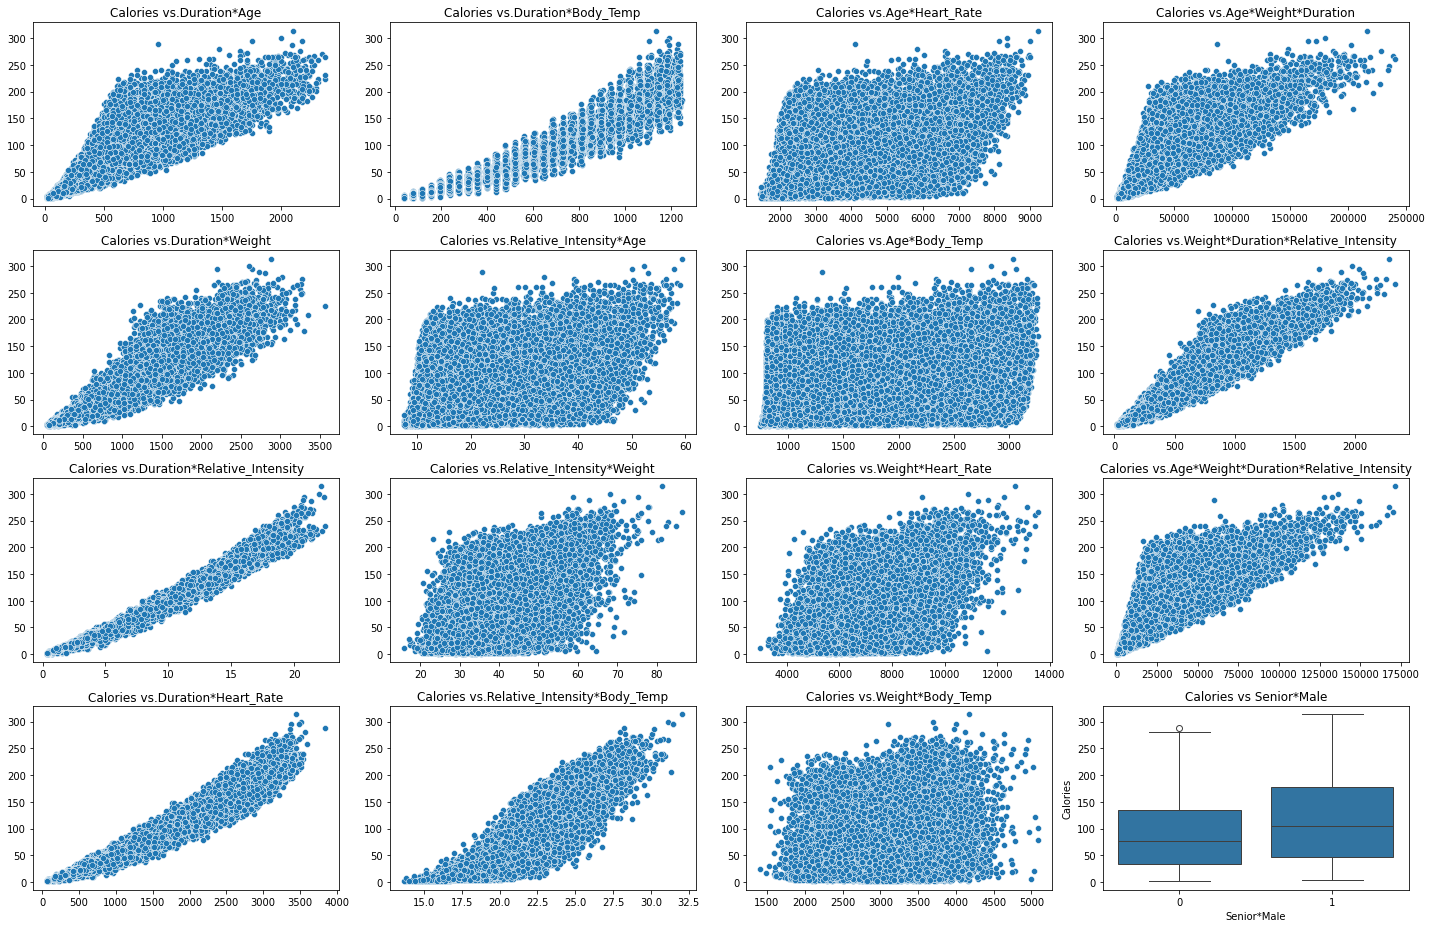

In [22]:
fig, axes = plt.subplots(4, 4, figsize=(20,13))
numeric_interactions = ['Duration*Age', 'Duration*Weight', 'Duration*Relative_Intensity', 'Duration*Heart_Rate', 'Duration*Body_Temp', 'Relative_Intensity*Age', 
                       'Relative_Intensity*Weight', 'Relative_Intensity*Body_Temp', 'Age*Heart_Rate', 'Age*Body_Temp', 'Weight*Heart_Rate', 'Weight*Body_Temp', 
                       'Age*Weight*Duration', 'Weight*Duration*Relative_Intensity', 'Age*Weight*Duration*Relative_Intensity']
i = 0
j = 0
# View the relationships between `Calories` and the newly created interaction terms
for interaction in numeric_interactions:
    sns.scatterplot(data=data, x=interaction, y='Calories', ax=axes[i, j])
    axes[i,j].set_title('Calories vs.' + interaction)
    axes[i,j].set_xlabel('')
    axes[i,j].set_ylabel('')

    i+=1
    if i==4:
        i=0
        j+=1

sns.boxplot(data, x='Senior*Male', y='Calories', ax=axes[3,3])
axes[3,3].set_title('Calories vs Senior*Male')
plt.tight_layout()
plt.show()

The interactions that appear to have a relationship with the target are:
- Duration*Age
- Duration*Body_Temp
- Age*Weight*Duration
- Duration*Weight
- Weight*Duration*Relative_Intensity
- Duration*Relative_Intensity
- Age*Weight*Duration*Relative_Intensity
- Duration*Heart_Rate
- Relative_Intensity*Body_Temp
- Senior*Male

## Modelling

In [23]:
# Save the original features
non_interactions = ['Male', 'Age', 'Weight', 'BMI', 'Heart_Rate', 'Relative_Intensity', '1.75^Body_Temp', 'Duration']

# Keep the interaction terms that show some significance
interactions = ['Duration*Age', 'Duration*Weight', 'Duration*Relative_Intensity', 'Duration*Heart_Rate', 
                'Duration*Body_Temp', 'Relative_Intensity*Body_Temp', 'Senior*Male', 'Age*Weight*Duration', 
                'Weight*Duration*Relative_Intensity', 'Age*Weight*Duration*Relative_Intensity']

#### Linear Model

In [24]:
# Prepare inputs for the Linear Model
linear_features = non_interactions + interactions
linear_target = 'sqrt(Calories)'

X_linear = data[linear_features]
y_linear = data[linear_target]

# Training-test split
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(X_linear, y_linear, train_size=0.75, random_state=seed) # A 75/25 split since that is the same as the competition

In [25]:
# Model Set-up
lm = LinearRegression(fit_intercept=True)

# Fit the model
lm.fit(X_train_linear, y_train_linear)

# Make predictions
lm_pred = lm.predict(X_test_linear)

# Ensure predictions are non-negative (RMLSE does not accept negative values)
lm_pred = non_negative(lm_pred)

In [26]:
# Concatenate all test set columns into a sinlge dataframe
y_test_squared = y_test_linear**2
y_test_squared.name = 'Calories'
test_linear = pd.concat([X_test_linear, y_test_squared, (pd.Series(lm_pred, name='Prediction', index=y_test_linear.index))**2], axis=1)
test_linear.head()

Male  Age  Weight        BMI  Heart_Rate  Relative_Intensity  \
User_ID                                                                  
14503730     1   30    92.0  24.194609       101.0            0.540107   
11137896     1   62    92.0  26.880935        87.0            0.528554   
15119665     0   59    55.0  24.773659        77.0            0.461908   
10896246     1   78   103.0  26.540236        89.0            0.580183   
13363046     1   20    88.0  26.277285        97.0            0.500000   

          1.75^Body_Temp  Duration  Duration*Age  Duration*Weight  \
User_ID                                                             
14503730    9.216372e+09      30.0         900.0           2760.0   
11137896    4.708844e+09      11.0         682.0           1012.0   
15119665    2.034030e+09       2.0         118.0            110.0   
10896246    4.452568e+09       9.0         702.0            927.0   
13363046    6.966922e+09      16.0         320.0           1408.0   

          Duration*Relative_Intensity  Duration*Heart_Rate  \
User_ID                                                      
14503730                    16.203209               3030.0   
11137896                     5.814095                957.0   
15119665                     0.923815                154.0   
10896246                     5.221643                801.0   
13363046                     8.000000               1552.0   

          Duration*Body_Temp  Relative_Intensity*Body_Temp  Senior*Male  \
User_ID                                                                   
14503730              1230.0                     22.144385            0   
11137896               437.8                     21.036452            1   
15119665                76.6                     17.691062            0   
10896246               357.3                     23.033246            1   
13363046               648.0                     20.250000            0   

          Age*Weight*Duration  Weight*Duration*Relative_Intensity  \
User_ID                                                             
14503730              82800.0                         1490.695187   
11137896              62744.0                          534.896719   
15119665               6490.0                           50.809838   
10896246              72306.0                          537.829205   
13363046              28160.0                          704.000000   

          Age*Weight*Duration*Relative_Intensity  Calories  Prediction  
User_ID                                                                 
14503730                            44720.855615     165.0  159.420026  
11137896                            33163.596598      54.0   56.056813  
15119665                             2997.780444       7.0    6.535983  
10896246                            41950.677966      56.0   53.599376  
13363046                            14080.000000      69.0   69.615121

In [27]:
# Error Measure Score
print(f"Root Mean Squared Logarithmic Error (Linear Model): {round(RMSLE(test_linear['Calories'], test_linear['Prediction']), 6)}")

Root Mean Squared Logarithmic Error (Linear Model): 0.078132


In [28]:
# Examine the coefficients
print(pd.Series(lm.coef_, index=X_train_linear.columns))

Male                                     -2.423986e-01
Age                                       1.889794e-02
Weight                                   -2.122805e-04
BMI                                      -3.104805e-03
Heart_Rate                                9.947890e-02
Relative_Intensity                       -6.369598e-02
1.75^Body_Temp                            4.780182e-10
Duration                                  4.288437e+00
Duration*Age                             -7.147252e-03
Duration*Weight                          -9.907260e-03
Duration*Relative_Intensity               2.598066e+00
Duration*Heart_Rate                      -1.550316e-02
Duration*Body_Temp                       -9.030876e-02
Relative_Intensity*Body_Temp             -1.322730e-01
Senior*Male                               4.423446e-01
Age*Weight*Duration                       1.380842e-04
Weight*Duration*Relative_Intensity        1.738523e-02
Age*Weight*Duration*Relative_Intensity   -2.183708e-04
dtype: flo

These coefficients were not scaled before modelling, so we can't compare the coefficients one-to-one; however, the features close to zero such as 1.75^Body_Temp do not have much of an effect on the model, whereas Duration and Duration*Relative_Intensity have a big effect on the model.

#### ML Model

In [29]:
# Preparing Inputs
ML_features = non_interactions + interactions
ML_target = 'Calories'

X_ML = data[ML_features]
y_ML = data[ML_target]

# Training-test split
X_train_ML, X_test_ML, y_train_ML, y_test_ML = train_test_split(X_ML, y_ML, train_size=0.75, random_state=seed)

In [30]:
# Choose the model
rf = RandomForestRegressor(n_estimators=500, n_jobs=8, random_state=seed) # Use an appropriate number of cores

# Fit the model
rf.fit(X_train_ML, y_train_ML)

# Make predictions
pred_ML = rf.predict(X_test_ML)

# Ensure predictions are non-negative
pred_ML = non_negative(pred_ML)

In [31]:
# Put all the data used in testing into a single dataframe
test_ML = pd.concat([X_test_ML, y_test_ML, (pd.Series(pred_ML, name='Prediction', index=y_test_ML.index))], axis=1)
test_ML.head()

Male  Age  Weight        BMI  Heart_Rate  Relative_Intensity  \
User_ID                                                                  
14503730     1   30    92.0  24.194609       101.0            0.540107   
11137896     1   62    92.0  26.880935        87.0            0.528554   
15119665     0   59    55.0  24.773659        77.0            0.461908   
10896246     1   78   103.0  26.540236        89.0            0.580183   
13363046     1   20    88.0  26.277285        97.0            0.500000   

          1.75^Body_Temp  Duration  Duration*Age  Duration*Weight  \
User_ID                                                             
14503730    9.216372e+09      30.0         900.0           2760.0   
11137896    4.708844e+09      11.0         682.0           1012.0   
15119665    2.034030e+09       2.0         118.0            110.0   
10896246    4.452568e+09       9.0         702.0            927.0   
13363046    6.966922e+09      16.0         320.0           1408.0   

          Duration*Relative_Intensity  Duration*Heart_Rate  \
User_ID                                                      
14503730                    16.203209               3030.0   
11137896                     5.814095                957.0   
15119665                     0.923815                154.0   
10896246                     5.221643                801.0   
13363046                     8.000000               1552.0   

          Duration*Body_Temp  Relative_Intensity*Body_Temp  Senior*Male  \
User_ID                                                                   
14503730              1230.0                     22.144385            0   
11137896               437.8                     21.036452            1   
15119665                76.6                     17.691062            0   
10896246               357.3                     23.033246            1   
13363046               648.0                     20.250000            0   

          Age*Weight*Duration  Weight*Duration*Relative_Intensity  \
User_ID                                                             
14503730              82800.0                         1490.695187   
11137896              62744.0                          534.896719   
15119665               6490.0                           50.809838   
10896246              72306.0                          537.829205   
13363046              28160.0                          704.000000   

          Age*Weight*Duration*Relative_Intensity  Calories  Prediction  
User_ID                                                                 
14503730                            44720.855615     165.0     172.194  
11137896                            33163.596598      54.0      55.164  
15119665                             2997.780444       7.0       7.210  
10896246                            41950.677966      56.0      54.502  
13363046                            14080.000000      69.0      70.420

In [32]:
# Error Measure Score
print(f"Root Mean Squared Logarithmic Error (Random Forest Model): {RMSLE(test_ML['Calories'], test_ML['Prediction']):.6f}")

Root Mean Squared Logarithmic Error (Random Forest Model): 0.038906


In [33]:
importance_frame = pd.DataFrame({'Feature': X_train_ML.columns, 'Importance':rf.feature_importances_}).sort_values(by='Importance', ascending=False).reset_index(drop=True)
importance_frame

Feature  Importance
0              Duration*Relative_Intensity    0.978457
1       Weight*Duration*Relative_Intensity    0.006290
2                               Heart_Rate    0.003770
3             Relative_Intensity*Body_Temp    0.002935
4                       Relative_Intensity    0.002259
5                                     Male    0.002137
6                      Duration*Heart_Rate    0.000988
7                      Age*Weight*Duration    0.000644
8                              Senior*Male    0.000537
9                                   Weight    0.000494
10  Age*Weight*Duration*Relative_Intensity    0.000426
11                                     BMI    0.000302
12                         Duration*Weight    0.000251
13                            Duration*Age    0.000151
14                      Duration*Body_Temp    0.000141
15                                     Age    0.000103
16                          1.75^Body_Temp    0.000086
17                                Duration    0.000027

For the random forest model, we can see that Duration*Relative_Intensity is the most important feature to increase purity.

## Simplify the Model

In [34]:
# Keep the top four interaction terms based on feature importance
interactions_to_keep = ['Duration*Relative_Intensity', 'Weight*Duration*Relative_Intensity', 'Relative_Intensity*Body_Temp', 'Duration*Heart_Rate']

In [35]:
# Preparing Inputs
features = non_interactions + interactions_to_keep
target = 'Calories'

X = data[features]
y = data[target]

# Training-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=seed)

In [36]:
### Source: geeksforgeeks.org
#----------------------------

# Parameters to check
param_distributions_rf = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False],
    'max_features': ['sqrt', 'log2']
}

# Use RandomizedSearchCV() to find best likely parameters
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestRegressor(n_jobs=8, random_state=seed), 
    param_distributions=param_distributions_rf, 
    n_iter=30,
    cv=5,
    n_jobs=8, # Use an appropriate number of cores depending on your machine
    verbose=2,
    random_state=seed
)

start = time.time() # Start Runtime Timer

# Fit the model to the training data
random_search_rf.fit(X_train, y_train)

end = time.time() # End Runtime Timer

# Print Hyperparameter Tuning Results
print('\nRandom Forest Hyperparameter Tuning')
print('-----------------------------')
print(f'Runtime: {(end-start)/60:.2f} minutes')
print('Parameter Tuning Results:')
for parameter, result in random_search_rf.best_params_.items():
    print(f'\t-{parameter}: {result}')

# Save the best parameters
best_rf_params = random_search_rf.best_params_

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.1s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.2s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   3.2s
[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   1.3s
[CV] END bootstrap=False, max_depth=15, max_features=log2, min_samples_leaf=2, min_samples_split=2, n_estimators=100

##### Tuning Results
Tuned Model with Random Search CV:
- n_estimators: 400
- max_depth: 20
- min_samples_split: 5
- min_samples_leaf: 1
- max_features: sqrt
- bootstrap: False

In [37]:
# Make predictions with the tuned model
pred = random_search_rf.predict(X_test)

# Ensure predictions are non-negative
pred = non_negative(pred)

# Create a test dataframe
test = pd.concat([X_test, y_test, (pd.Series(pred, name='Prediction', index=y_test.index))], axis=1)

# Error Measure Score
print(f"Root Mean Squared Logarithmic Error (Tuned Random Forest): {RMSLE(test['Calories'], test['Prediction']):.6f}")

# Show results
test.head()

Root Mean Squared Logarithmic Error (Tuned Random Forest): 0.040327


Male  Age  Weight        BMI  Heart_Rate  Relative_Intensity  \
User_ID                                                                  
14503730     1   30    92.0  24.194609       101.0            0.540107   
11137896     1   62    92.0  26.880935        87.0            0.528554   
15119665     0   59    55.0  24.773659        77.0            0.461908   
10896246     1   78   103.0  26.540236        89.0            0.580183   
13363046     1   20    88.0  26.277285        97.0            0.500000   

          1.75^Body_Temp  Duration  Duration*Relative_Intensity  \
User_ID                                                           
14503730    9.216372e+09      30.0                    16.203209   
11137896    4.708844e+09      11.0                     5.814095   
15119665    2.034030e+09       2.0                     0.923815   
10896246    4.452568e+09       9.0                     5.221643   
13363046    6.966922e+09      16.0                     8.000000   

          Weight*Duration*Relative_Intensity  Relative_Intensity*Body_Temp  \
User_ID                                                                      
14503730                         1490.695187                     22.144385   
11137896                          534.896719                     21.036452   
15119665                           50.809838                     17.691062   
10896246                          537.829205                     23.033246   
13363046                          704.000000                     20.250000   

          Duration*Heart_Rate  Calories  Prediction  
User_ID                                              
14503730               3030.0     165.0  163.791250  
11137896                957.0      54.0   54.170208  
15119665                154.0       7.0    7.194583  
10896246                801.0      56.0   54.802292  
13363046               1552.0      69.0   70.947415

In [38]:
pd.DataFrame({'Feature': X_train.columns, 'Importance':random_search_rf.best_estimator_.feature_importances_}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

Feature  Importance
0          Duration*Relative_Intensity    0.301270
1                  Duration*Heart_Rate    0.196899
2                             Duration    0.192902
3   Weight*Duration*Relative_Intensity    0.098581
4                           Heart_Rate    0.071427
5                       1.75^Body_Temp    0.055875
6         Relative_Intensity*Body_Temp    0.042312
7                   Relative_Intensity    0.032352
8                                 Male    0.002937
9                               Weight    0.002322
10                                 Age    0.002156
11                                 BMI    0.000965

## Conclusion
We find that the Random Forest model outperforms the linear model in minimizing prediction error. After simplifying and tuning the Random Forest model, an RMSLE of 0.040327 was achieved; however, the more complex Random Forest model performs slightly better than the tuned one, suggesting that increased model complexity may be beneficial as the competition is based on prediction accuracy. 

Additionally, we can interpret variable significance from both the linear model and the Random Forest model by interpreting the coefficients and feature importance respectively. We find that duration is by far the strongest predictor - particularly the interaction between duration and relative intensity.